In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os 

from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Coronal Model


In [ ]:
%cd /content/drive/My Drive/coronal_model

/content/drive/My Drive/coronal_model


In [ ]:
files_train = 0

cwd = os.getcwd()

folder = '/content/drive/My Drive/coronal_model/coronal_train'

for sub_folder in os.listdir(folder):
    root, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)

print(files_train)


img_width, img_height = 256, 256
train_data_dir = "/content/drive/My Drive/coronal_model/coronal_train"

nb_train_samples = files_train

batch_size = 32
num_classes = 2

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.10)


train_generator = datagen.flow_from_directory(
train_data_dir,
shuffle = True,
subset='training',
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

valid_generator = datagen.flow_from_directory(
train_data_dir,
shuffle = True,
subset='validation',
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)

headmodel = Dense(32, activation = 'relu')(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(2, activation = 'sigmoid')(headmodel)

model_coronal = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model_coronal.compile(loss = 'categorical_crossentropy', 
                      optimizer=optimizers.SGD(lr=0.001, 
                                               momentum=0.9, 
                                               nesterov=True), 
                      metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='auto', verbose=1, 
                              patience=20,min_delta=0)

checkpointer = ModelCheckpoint(filepath="coronal_weights.h5", 
                               verbose=1, 
                               save_best_only=True, 
                               monitor='val_accuracy',
                               mode='auto', 
                               save_weights_only=False, 
                               period=1)

In [ ]:
history = model_coronal.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 32, epochs = 30, 
                    validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 32, 
                    callbacks=[checkpointer, earlystopping])

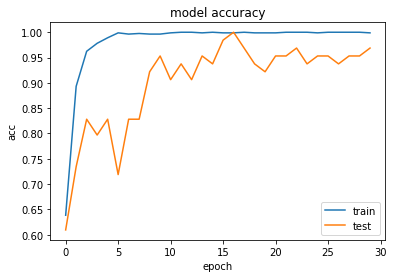

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

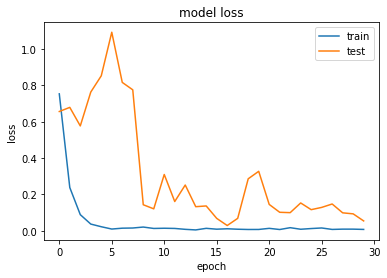

In [ ]:
# Plotting Loss of model (Training & Validation)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Axial Model

In [ ]:
%cd /content/drive/My Drive/axial_model

In [ ]:
files_train = 0
files_test = 0

cwd = os.getcwd()

folder = '/content/drive/My Drive/axial_model/axial_train'

for sub_folder in os.listdir(folder):
    root, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)

img_width, img_height = 256, 256
train_data_dir = "/content/drive/My Drive/axial_model/axial_train"

nb_train_samples = files_train
print(files_train)

batch_size = 32
num_classes = 2

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., 
                             shear_range=0.02, 
                             rotation_range=25,
                             width_shift_range = 0.1, 
                             height_shift_range = 0.1,
                             zoom_range = 0.1,
                             brightness_range = [1.1, 1.5],
                             horizontal_flip=True, 
                             validation_split = 0.35)

train_generator = datagen.flow_from_directory(
train_data_dir,
shuffle = True,
subset='training',
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

valid_generator = datagen.flow_from_directory(
train_data_dir,
shuffle = True,
subset='validation',
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)


headmodel = Dense(16, activation = "relu")(headmodel)
headmodel = Dropout(0.6)(headmodel)

#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'sigmoid')(headmodel)

model_axial = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model_axial.compile(loss = 'categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True), metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='auto', 
                              verbose=1, 
                              patience=20,
                              min_delta=0)

In [ ]:
checkpointer = ModelCheckpoint(filepath="axial_weights.h5", 
                               verbose=1, save_best_only=True, 
                               monitor='val_accuracy',
                               mode='auto', 
                               save_weights_only=False, 
                               period=1)

In [ ]:
history = model_axial.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 32, 
                    epochs = 10, 
                    validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 32, 
                    callbacks=[checkpointer, earlystopping]
                    )

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# Plotting Loss of model (Training & Validation)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Sagittal Model

In [ ]:
%cd /content/drive/My Drive/sagittal_model

In [ ]:
files_train = 0

cwd = os.getcwd()

folder = '/content/drive/My Drive/sagittal_model/sagittal_train'

for sub_folder in os.listdir(folder):
    root, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)

print(files_train)


img_width, img_height = 256, 256
train_data_dir = "/content/drive/My Drive/sagittal_model/sagittal_train"
nb_train_samples = files_train
batch_size = 32
num_classes = 2

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.20)

train_generator = datagen.flow_from_directory(
train_data_dir,
shuffle = True,
subset='training',
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

valid_generator = datagen.flow_from_directory(
train_data_dir,
shuffle = True,
subset='validation',
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)

headmodel = Dense(32, activation = "relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)

#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(2, activation = 'sigmoid')(headmodel)

model_sagittal = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model_sagittal.compile(loss = 'categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True), metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=20,min_delta=0)
checkpointer = ModelCheckpoint(filepath="sagittal_weights.h5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='auto', save_weights_only=False, period=1)

In [ ]:
history = model_sagittal.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 32, epochs = 30, 
                    validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 32, 
                    callbacks=[checkpointer, earlystopping])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# Plotting Loss of model (Training & Validation)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()